In [1]:
import re
import os

import pandas as pd
import chardet
import nltk
import textwrap
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download("stopwords")
nltk.download("punkt")
from contractions import contractions_dict
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kysgattu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kysgattu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def expand_contractions(text, contraction_map=None):
    if contraction_map is None:
        contraction_map = contractions_dict

    # Using regex for getting all contracted words
    contractions_keys = '|'.join(re.escape(key) for key in contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    expanded_text = contractions_pattern.sub(lambda match: contraction_map.get(match.group(0), match.group(0)), text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


In [3]:
# Function to detect file encoding
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

In [4]:
# Set the base directory
base_dir = "data/BBCNewsSummary/News Articles"
output_dir = "data/BBCNewsSummaryCSV"  # Output directory

# Check if the output directory exists, and create it if not
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get the list of classes (subfolder names)
classes = os.listdir(base_dir)
dfs = {}
# Create dataframes and write to CSV files for each class
for class_name in classes:
    # Define the paths for news articles and summaries
    news_articles_path = os.path.join(base_dir, class_name)
    summaries_path = os.path.join("data/BBCNewsSummary/Summaries", class_name)

    # Get the list of file names in both directories
    news_articles_files = os.listdir(news_articles_path)
    summaries_files = os.listdir(summaries_path)

    # Match file names
    common_files = set(news_articles_files) & set(summaries_files)

    # Create dataframe
    df_list = []

    # Read content from files and populate dataframe
    for filename in sorted(common_files):  # Sort by filename
        news_article_file_path = os.path.join(news_articles_path, filename)
        summary_file_path = os.path.join(summaries_path, filename)

        # Detect encoding
        news_encoding = detect_encoding(news_article_file_path)
        summary_encoding = detect_encoding(summary_file_path)

        try:
            with open(news_article_file_path, 'r', encoding=news_encoding) as news_file, \
                    open(summary_file_path, 'r', encoding=summary_encoding) as summary_file:
                news_content = news_file.read()
                summary_content = summary_file.read()
                

                # Extract file name without extension
                file_name_without_extension = os.path.splitext(filename)[0]

                # Generate the new entry in the filename
                new_filename = f'{class_name}_{file_name_without_extension}'

                df_list.append({'filename': new_filename, 'newsarticle': news_content, 'summary': summary_content})

        except UnicodeDecodeError:
            print(f"UnicodeDecodeError: Could not read {filename}. Skipping this file.")

    # Create dataframe from the list and sort by filename
    df = pd.DataFrame(df_list).sort_values(by='filename')
    
    # Save dataframe to the dictionary
    dfs[class_name] = df


    # # Write dataframe to CSV in the output directory
    # csv_filename = os.path.join(output_dir, f'{class_name}_data.csv')
    # df.to_csv(csv_filename, index=False)
    # print(f'Dataframe for {class_name} written to {csv_filename}')


In [5]:
business = dfs['business']
entertainment = dfs['entertainment']
sport = dfs['sport']
politics = dfs['politics']
tech = dfs['tech']

In [6]:
sample_text = business['newsarticle'][242] 

In [7]:
sample_text

"Making your office work for you\n\nOur mission to brighten up your working lives continues - and this time, we're taking a long hard look at your offices.\n\nOver the next few months, our panel of experts will be listening to your gripes about where you work, and suggesting ways to make your workspace more efficient, more congenial or simply prettier. This week, we're hearing from Marianne Petersen, who is planning to convert a barn in Sweden into a base for her freelance writing work. Click on the link under her photograph to read her story, and then scroll down to see what the panel have to say. And if you want to take part in the series, go to the bottom of the story to find out how to get in touch.\n\nWorking from home presents a multitude of challenges. Understanding your work personality allows you to work in terms of your own style. Do you feel confident about your work output without conferring with others? Are you able to retain discipline and self motivate to get the job don

In [8]:
# entertainment = pd.read_csv('data/BBCNewsSummaryCSV/entertainment_data.csv') 
# sport = pd.read_csv('data/BBCNewsSummaryCSV/sport_data.csv')
# tech = pd.read_csv('data/BBCNewsSummaryCSV/tech_data.csv')
# business = pd.read_csv('data/BBCNewsSummaryCSV/business_data.csv')
# politics = pd.read_csv('data/BBCNewsSummaryCSV/politics_data.csv')

In [9]:
training_dataset = pd.concat([business,politics,tech], ignore_index=True)
testing_dataset = pd.concat([entertainment,sport], ignore_index=True)

In [10]:
print("Training size:",training_dataset.size)
print("Testing size:",testing_dataset.size)

Training size: 3984
Testing size: 2691


In [11]:
training_dataset = training_dataset.sample(frac=1).reset_index(drop=True)
testing_dataset = testing_dataset.sample(frac=1).reset_index(drop=True)

In [12]:
training_dataset['newsarticle'] = training_dataset['newsarticle'].apply(expand_contractions)
testing_dataset['newsarticle'] = testing_dataset['newsarticle'].apply(expand_contractions)

In [13]:
stop_words = stopwords.words("english")

In [14]:
def wrap(x):
    return textwrap.fill(x,replace_whitespace=False,fix_sentence_endings=True)

In [15]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from scipy import spatial
import networkx as nx

In [16]:
def textRank(text):
    sentences=sent_tokenize(text)
    sentences_clean=[re.sub(r'[^\w\s]','',sentence.lower()) for sentence in sentences]
    stop_words = stopwords.words('english')
    sentence_tokens=[[words for words in sentence.split(' ') if words not in stop_words] for sentence in sentences_clean]
    w2v=Word2Vec(sentence_tokens,vector_size=1,min_count=1,epochs=1000)
    sentence_embeddings=[[w2v.wv[word][0] for word in words] for words in sentence_tokens]
    max_len=max([len(tokens) for tokens in sentence_tokens])
    sentence_embeddings=[np.pad(embedding,(0,max_len-len(embedding)),'constant') for embedding in sentence_embeddings]
    similarity_matrix = np.zeros([len(sentence_tokens), len(sentence_tokens)])
    for i,row_embedding in enumerate(sentence_embeddings):
        for j,column_embedding in enumerate(sentence_embeddings):
            similarity_matrix[i][j]=1-spatial.distance.cosine(row_embedding,column_embedding)
    nx_graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(nx_graph)
    top_sentence={sentence:scores[index] for index,sentence in enumerate(sentences)}
    top=dict(sorted(top_sentence.items(), key=lambda x: x[1], reverse=True)[:4])
    summary = ''
    for sent in sentences:
        if sent in top.keys():
            summary = summary+sent
            # print(summary)
    return summary

In [17]:
textRank(training_dataset['newsarticle'][1])

'He added: "Lots of ministers believe Tony Blair will attempt to move Gordon Brown out of the Treasury after the election.Senior MPs are expected to raise concerns about the latest reports of infighting at the regular meeting of Labour backbenchers on Monday.Tory leader Michael Howard accused the prime minister and Mr Brown of"squabbling like schoolboys".Liberal Democrat parliamentary chairman Matthew Taylor said the personal ambition of Mr Blair and Mr Brown was "getting in the way of good government".'

In [18]:
train_df, val_df = train_test_split(training_dataset, test_size=0.2, random_state=42)
test_df = testing_dataset[0:len(val_df)]

# testing_dataset = [0:10]

In [19]:
import pandas as pd
from rouge_score import rouge_scorer
from bert_score import score as bert_score


# Function to apply summarizer and calculate scores for each row
def tr_summarize(row):
    news_article = row['newsarticle']
    actual_summary = row['summary']

    # Generate extractive summary
    extractive_summary_str = textRank(news_article)
    
    # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])
    rouge_scores = scorer.score(extractive_summary_str, actual_summary)

    # Compute BERT scores
    _, _, bert_f1 = bert_score([extractive_summary_str], [actual_summary], lang='en', model_type='bert-base-uncased')

    return pd.Series({
        'predicted_summary': extractive_summary_str,
        'rouge1_precision': rouge_scores['rouge1'].precision,
        'bert_score': bert_f1.item()
    })

# Apply the process_row function to each row in the DataFrame
result_df = test_df.apply(tr_summarize, axis=1)

# Concatenate the result_df with the original DataFrame
tr_result_dataset = pd.concat([test_df, result_df], axis=1)

# Print the updated DataFrame
# print(testing_dataset)


/Users/kysgattu/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [20]:
tr_result_dataset.head()

,filename,newsarticle,summary,predicted_summary,rouge1_precision,bert_score
0,sport_455,Slovakia seal Hopman Cup success\n\nSlovakia c...,"Dominik Hrbaty, who had not lost a set in his ...",Slovakias win made up for last years final def...,0.282443,0.558991
1,entertainment_323,Vera Drake leads UK Oscar hopes\n\nMike Leighs...,Kate Winslet was also nominated in the best ac...,And Clive Owen and Sophie Okonedo both got nom...,0.234513,0.625201
2,sport_376,Wasps 31-37 Leicester\n\nLeicester withstood a...,The closing moments saw desperate defence from...,The Tigers stormed 22-6 ahead within 18 minute...,0.284153,0.663714
3,entertainment_244,Ten-year tragedy of missing Manic\n\nRichey Ed...,The Manic Street Preachers release their first...,"Singer/guitarist James Dean Bradfield, bassist...",0.182759,0.577712
4,sport_048,Greek pair set for hearing\n\nKostas Kenteris ...,Kenteris and Thanou also face criminal charges...,Athletics ruling body took action against the ...,0.250000,0.651474


In [22]:
tr_result_dataset['predicted_summary'][0]

'Slovakias win made up for last years final defeat to the United States."I also feel a little sorry for Guillermo because I get very excited whenever I play for my country."I was so nervous because I really wanted to win for the team and for Dominik as he played so well all week," she said."I did not think I was playing my best but I just tried to hang in there and fight hard for every point for my country."'

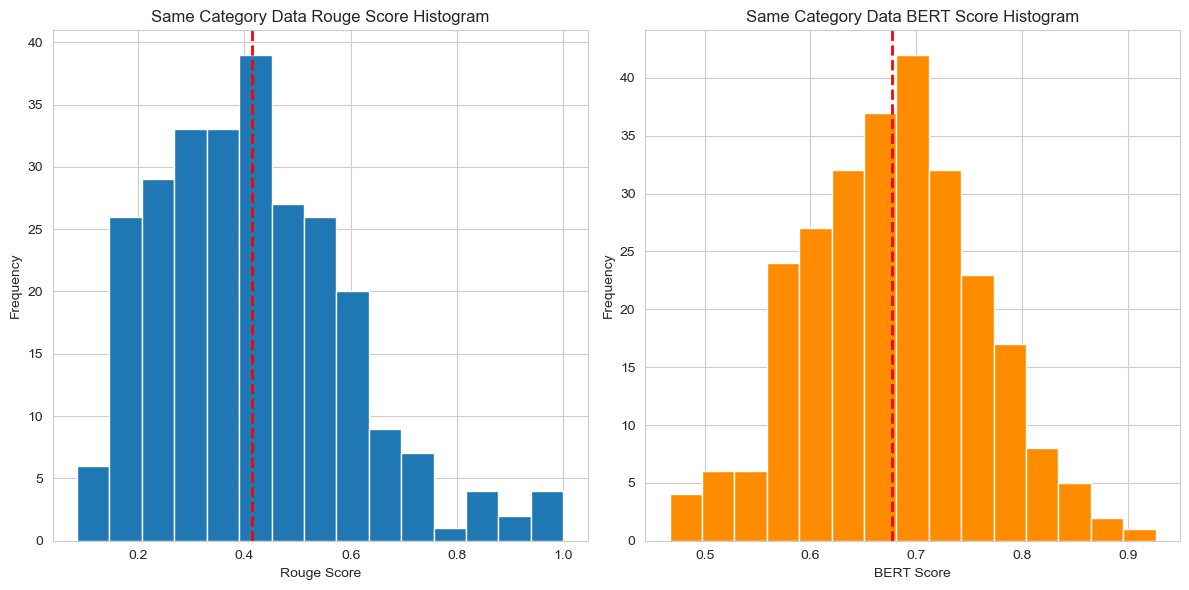

In [23]:
import matplotlib.pyplot as plt

# Calculate mean values
textRank_mean_rouge = np.mean(tr_result_dataset['rouge1_precision'])
textRank_mean_bert = np.mean(tr_result_dataset['bert_score'])


# Create separate histogram plots for Rouge and BERT Scores
plt.figure(figsize=(12, 6))
# plt.title('Same Category Data')

# Rouge Score Histogram
plt.subplot(1, 2, 1)
plt.hist(tr_result_dataset['rouge1_precision'], bins=15, color='#1f77b4')
plt.axvline(textRank_mean_rouge, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {textRank_mean_rouge:.3f}')
plt.title('Same Category Data Rouge Score Histogram')
plt.xlabel('Rouge Score')
plt.ylabel('Frequency')

# BERT Score Histogram
plt.subplot(1, 2, 2)
plt.hist(tr_result_dataset['bert_score'], bins=15, color='darkorange')
plt.axvline(textRank_mean_bert, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {textRank_mean_bert:.3f}')
plt.title('Same Category Data BERT Score Histogram')
plt.xlabel('BERT Score')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [24]:
get_ipython().system('jupyter nbconvert --to script TextRank-ExtractiveSummarizer.ipynb')

[NbConvertApp] Converting notebook TextRank-ExtractiveSummarizer.ipynb to script
[NbConvertApp] Writing 9318 bytes to TextRank-ExtractiveSummarizer.py
